# Binary Image Classification for IDC Breast Cancer Detection

Authors: Achsah Jojo, Sam Jacobs, Jody Barnett, Athena Rita Burciaga

We will be doing binary classification on images based on the presence of IDC (Invasive Ductal Carcinoma) Breast Cancer. Given a patient and a tissue sample from the patient, we will detect whether cancer cells are present. Our baseline goal is 80% accuracy, based on the accuracy achieved by previous models on the same dataset, and our stretch goal is 90% accuracy.

We will use the dataset found at https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images, containing 277,000 images, where approximately 199,000 samples are IDC positive and approximately 79,000 are IDC negative.


In [ ]:
import os
import logging
import contextlib
import sys



# Suppress TensorFlow logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Only show ERROR
os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"  # experimental
os.environ["TF_ENABLE_GPU_GMEM_PROFILER"] = "0"

#  Suppress absl logs
logging.getLogger('absl').setLevel(logging.ERROR)

sys.stderr = open(os.devnull, "w")


# Import TensorFlow after suppressing logs
import tensorflow as tf
from PIL import Image, ImageDraw
import re
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras import layers, models, optimizers
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

I0000 00:00:1765941562.547937    2053 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1765941562.612528    2053 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1765941562.612580    2053 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1765941562.614959    2053 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1765941562.615001    2053 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

# Load Images : DataFrame Implementation

There are two ways we can load the data into either Jupyter Notebook or Google Colab Notebook. Once we load the images, we need to find the correct files and extract the data from those files so we can have a organized dataset.

### Jupyter Notebook:

We just download the dataset on to our local machine and put the file path in th image_root variable.


### Google Colab
  
  When loading the images into this google colab notebook, we followed this method:

  1. Open Terminal and type !mkdir -p ~/.kaggle
  2. !cp kaggle.json ~/.kaggle/
  3, !chmod 600 ~/.kaggle/kaggle.json
  4. !kaggle datasets download -d paultimothymooney/breast-histopathology-images
  5. !unzip -q breast-histopathology-images.zip
  6. For image_root, we do "/content" instead of the filepath

In [ ]:
image_root = r"/mnt/c/Users/Sam/OneDrive/Desktop/AdvancedMachineLearning/AML_project_images"
image_paths = []
label = [] # 0 = non-IDC, 1 = IDC

data = []

pattern = r"(.*)_x(\d+)_y(\d+)_class(\d)\.png"

# Finds all PNG files with this pattern: patientID_x123_y456_class0.png
for root, dirs, files in os.walk(image_root):
    for file in files:
        if file.lower().endswith(".png"):
            full_path = os.path.join(root, file)
# Data is extracted to capture the  patient_id, x and y (tissue patch location) and label
            match = re.match(pattern, file)
            if match:
                patient_id = match.group(1)
                x = int(match.group(2))
                y = int(match.group(3))
                label = int(match.group(4))

                data.append([full_path, patient_id, x, y, label])

df = pd.DataFrame(
    data,
    columns=["filepath", "patient_id", "x", "y", "label"]
)

print("Total images:", len(df))
print("\nClass distribution:\n", df["label"].value_counts())
print("\nUnique patients:", df["patient_id"].nunique())

df.head()

Total images: 277524

Class distribution:
 label
0    198738
1     78786
Name: count, dtype: int64

Unique patients: 279


,filepath,patient_id,x,y,label
0,/mnt/c/Users/Sam/OneDrive/Desktop/AdvancedMach...,10253_idx5,1001,1001,0
1,/mnt/c/Users/Sam/OneDrive/Desktop/AdvancedMach...,10253_idx5,1001,1051,0
2,/mnt/c/Users/Sam/OneDrive/Desktop/AdvancedMach...,10253_idx5,1001,1101,0
3,/mnt/c/Users/Sam/OneDrive/Desktop/AdvancedMach...,10253_idx5,1001,1151,0
4,/mnt/c/Users/Sam/OneDrive/Desktop/AdvancedMach...,10253_idx5,1001,1201,0


This means that we have a substantial dataset with breast cancer images. Additionally, the 279 unique patients mean that each patient contributed around 1,990 image patches on average with some patients having more patches than others. Lastly, the class distribution shows significant class imbalance. This will affect our model training so that means we will most likely need to use class weights during training, do class balancing such as oversampling minority class or undersampling majority.



One important thing to be careful about is how we split the patient samples. Since a single patient can have many patches that look very similar, a random split could place patches from the same patient into both the training and testing sets. This would cause data leakage which would give us a false accuracy. To avoid this, the dataset must be split at the patient level first, ensuring that all patches from a single patient go into the same set.

## Create Subset for local training Update

Since we have a lot of patients and not a lot of time to train, we decided to create a subset dataset to make training go by faster.

In [ ]:
USE_SUBSET = False
SUBSET_PATIENTS = 100  # Adjust this number as needed

if USE_SUBSET:
    # Select a subset of patients to work with
    all_patients = df["patient_id"].unique()

    # Sample patients while maintaining class balance
    class_0_patients = df[df["label"] == 0]["patient_id"].unique()
    class_1_patients = df[df["label"] == 1]["patient_id"].unique()

    n_per_class = SUBSET_PATIENTS // 2
    selected_0 = np.random.choice(class_0_patients, min(n_per_class, len(class_0_patients)), replace=False)
    selected_1 = np.random.choice(class_1_patients, min(n_per_class, len(class_1_patients)), replace=False)

    selected_patients = list(selected_0) + list(selected_1)
    df = df[df["patient_id"].isin(selected_patients)].reset_index(drop=True)

    print(f"\n{'='*50}")
    print(f"USING SUBSET: {len(selected_patients)} patients, {len(df)} images")
    print(f"{'='*50}")
    print("Subset class distribution:\n", df["label"].value_counts())

## Sample Images
Randomly selects up to 16 samples from the breast cancer dataset, adds patient and label metadata onto each image, and arranges the processed images into a 4-column grid for better visualization on how the images look.

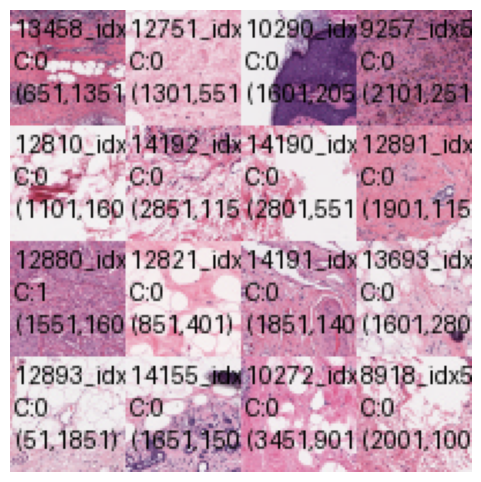

In [ ]:
#Loads images from disk
sample_size = min(16, len(data))
samples = random.sample(data, sample_size)

images = []
#Resizes it to 50×50 and draws text on it showing patient ID, label, and coordinates
for path, patient, x, y, label in samples:
    img = Image.open(path).resize((50, 50)).convert("RGB")
    draw = ImageDraw.Draw(img)

    draw.text(
        (2, 2),
        f"{patient}\nC:{label}\n({x},{y})",
        fill="black"
    )
    # Converts to a NumPy array
    images.append(np.array(img))

# arranges all the processed images into a grid
cols = 4
rows = (len(images) + cols - 1) // cols

h, w, c = images[0].shape
grid_img = np.zeros((rows*h, cols*w, c), dtype=np.uint8)

for idx, img in enumerate(images):
    r = idx // cols
    c_ = idx % cols
    grid_img[r*h:(r+1)*h, c_*w:(c_+1)*w] = img

#displays the grid
plt.figure(figsize=(6,6))
plt.imshow(grid_img)
plt.axis("off");

## Train Test Split

We will split our data carefully for training, validation, and testing. First, we will perform a patient-level split to ensure that all images from the same patient remain in the same subset, preventing data leakage. We will use a standard 70:30 train–test ratio, and within that structure, we will further split to create 15% validation and 15% test sets. This approach helps ensure that our evaluation is accurate and reflects true model performance.

In [ ]:
# Get unique patient IDs
patients = df["patient_id"].unique()

# Split patients into train and temp
train_patients, temp_patients = train_test_split(
    patients,
    test_size=0.30,
    random_state=42
)

# Split temp into validation and test
val_patients, test_patients = train_test_split(
    temp_patients,
    test_size=0.50,        # 15% val, 15% test
    random_state=42
)

# Build DataFrames based on patient assignment
train_df = df[df["patient_id"].isin(train_patients)].reset_index(drop=True)
val_df   = df[df["patient_id"].isin(val_patients)].reset_index(drop=True)
test_df  = df[df["patient_id"].isin(test_patients)].reset_index(drop=True)

# Summary
print("Train images:", len(train_df), "Class distribution:\n", train_df["label"].value_counts())
print("\nValidation images:", len(val_df), "Class distribution:\n", val_df["label"].value_counts())
print("\nTest images:", len(test_df), "Class distribution:\n", test_df["label"].value_counts())
print("\nUnique patients -- Train:", train_df["patient_id"].nunique(),
      "Val:", val_df["patient_id"].nunique(),
      "Test:", test_df["patient_id"].nunique())

Train images: 194268 Class distribution:
 label
0    139713
1     54555
Name: count, dtype: int64

Validation images: 42589 Class distribution:
 label
0    32363
1    10226
Name: count, dtype: int64

Test images: 40667 Class distribution:
 label
0    26662
1    14005
Name: count, dtype: int64

Unique patients -- Train: 195 Val: 42 Test: 42


## Preprocess Images

We will creating a TensorFlow data pipeline that loads and preprocess the breast cancer images for model training.

In [ ]:
IMG_SIZE = (75,75)
BATCH_SIZE = 16

#read from the file, decode to RGB, resize, normalize, cast to float.
def preprocess_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    label = tf.cast(label, tf.float32)
    return img, label

def df_to_dataset(df, shuffle=True, batch_size=BATCH_SIZE):
    paths = df["filepath"].values
    labels = df["label"].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(preprocess_image, num_parallel_calls=2)
    if shuffle:
        ds = ds.shuffle(buffer_size=500)
    ds = ds.batch(batch_size).prefetch(1)
    return ds

train_ds = df_to_dataset(train_df, shuffle=True)
val_ds   = df_to_dataset(val_df, shuffle=False)
test_ds  = df_to_dataset(test_df, shuffle=False)


The original images are 50×50 pixels, but we upscale them to 75×75 so the CNN has more spatial information to learn from and to match the input size requirements of the Inception model. Also, since this is a binary classification task, we use a sigmoid output layer with a binary_crossentropy loss function, which expects float labels rather than integers. To improve training stability, we normalize the data so gradients behave smoothly and convergence would be faster. Batching further improves training speed and produces more reliable gradient updates, while prefetching prepares the next batch in the background to maximize GPU utilization. Finally, shuffling the training data is important so the model does not accidentally learn the order of the dataset. TensorFlow’s Dataset API is what allows for this efficient streaming, batching, preprocessing, and shuffling of data in parallel.

## Pretraining model with InceptionV3
Creating a transfer learning model using InceptionV3 pretrained on ImageNet. We will be comapring this model to a simple CNN model to see which model is better at finding out if breast cancer cells are present in a image.

In [ ]:
#Base model
base_model = InceptionV3(
    weights="imagenet",
    include_top=False,
    input_shape=(*IMG_SIZE, 3)
)
# freeze the previous layers
base_model.trainable = False

#Data augmentation INSIDE model
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])

#Full model
inputs = layers.Input(shape=(*IMG_SIZE, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 75, 75, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 75, 75, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 1, 1, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,065,185 (84.17 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

We are using InceptionV3 as our pretrained model because it is  trained on ImageNet with 1.4M images, and 1000 classes. We will be removing the final classification layers  since we will be adding our own for cancer detection. We will also be freezes all InceptionV3 layers because we are assuming that all these pretrained features are already good and to fasten the training process. We are also doing data augmentation which is using artificial training variations to prevent overfitting by doing different flips and rotations.

Then we move into the classic CNN structure and use a sigmoid dense layer to output a single probability of 0 or 1 to determine if cancer cell is present. For compilation, we will be using Adam Optimizer since it has the adaptive learning rate scheduling, we will also use binary crossentropy for our loss since this is a binary classification problem and we will track accuracy.

A noteworthy aspect about the summary section is that, with 277k images and ~22 million parameters, at first glance it might mean we would get a lot of overfitting, since we have more parameters than data, however, since this is for a pretaried model, it has already learned general visual features from a huge dataset like ImageNet, so in reality, we are just fine-tuning it and not training from scratch.

## Class Balancing
This calculates class weights for our training labels so our model does not become biased toward the majority class.

In [ ]:
classes = np.array([0, 1])
cw = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=train_df["label"].values
)

class_weights = {0: cw[0], 1: cw[1]}
print("Class weights:", class_weights)


Class weights: {0: 0.6952395267441112, 1: 1.7804784162771514}


## Callbacks, Training and Optimization
Saves the best model during training, stops training early when it stops improving, reduces the learning rate when progress is flatling. These callbacks help from overfitting, resource intensive sessions, and getting stuck in bad optimization regions and vanishing gradients. `

In [ ]:
checkpoint = ModelCheckpoint(
    "best_inception_idc.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

# Train model
history = model.fit(
    train_ds,
    epochs=15,
    validation_data=val_ds,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

Epoch 1/15
12142/12142 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8167 - loss: 0.4235
Epoch 1: val_accuracy improved from None to 0.76381, saving model to best_inception_idc.keras
12142/12142 ━━━━━━━━━━━━━━━━━━━━ 580s 47ms/step - accuracy: 0.8149 - loss: 0.4256 - val_accuracy: 0.7638 - val_loss: 0.5464 - learning_rate: 0.0010
Epoch 2/15
12142/12142 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8190 - loss: 0.4228
Epoch 2: val_accuracy improved from 0.76381 to 0.78126, saving model to best_inception_idc.keras
12142/12142 ━━━━━━━━━━━━━━━━━━━━ 612s 50ms/step - accuracy: 0.8195 - loss: 0.4244 - val_accuracy: 0.7813 - val_loss: 0.5311 - learning_rate: 0.0010
Epoch 3/15
12140/12142 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8254 - loss: 0.4225
Epoch 3: val_accuracy improved from 0.78126 to 0.78793, saving model to best_inception_idc.keras
12142/12142 ━━━━━━━━━━━━━━━━━━━━ 461s 38ms/step - accuracy: 0.8225 - loss: 0.4249 - val_accuracy: 0.7879 - val_loss: 0.5322 - learning_rate: 0.

We wanted to monitor validation accuracy to see how the model performs on unseen data. We also are using early stopping so we can stop if we get a good accuracy earlier than ending the epoch. We choose our patience as 5 because after some trial and error, 5 is the one that gives the model a chance to improve, but also stops if it is really stuck. Lastly, we did ReduceLROnPlateau because we want to reduce our learning rate if the model is getting stuck. We want to ensure that the values are big enough that it makes an impact and does not stall the training process.

Our 81% validation accuracy during training epochs indicate that our model correctly classifies about 80% of images correctly. Additionally, the similar  train and val accuracy shows that there is not too much overfitting. This means that using the pretrained model, we were able to have a good generalization of the breast cancer images.

### Simple CNN Model

We want to compare how well a pretraiend model works compared a simple model and find out which could give us better accuracy.

In [ ]:
simple_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(75, 75, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

simple_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

simple_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_94 (Conv2D)              │ (None, 73, 73, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_96 (Conv2D)              │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,321 (3.42 MB)

 Trainable params: 896,321 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

Here, we are sticking with a basic CNN model with 3 Convolutional layers, 3 Maxpooling layers, Dropout and Dense layer. In the model summary, we have about 800k parameters which is not ideal since we have more paramters than our 277k data which means there is a higher chance of getting a bad model.

In [ ]:
# Define callbacks
checkpoint_simple = ModelCheckpoint(
    'best_simple_idc.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop_simple = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr_simple = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Train the model
history_simple = simple_model.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds,
    class_weight=class_weights,
    callbacks=[checkpoint_simple, early_stop_simple, reduce_lr_simple]
)

Epoch 1/5
12142/12142 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8430 - loss: 0.3871
Epoch 1: val_accuracy improved from None to 0.80091, saving model to best_simple_idc.h5
12142/12142 ━━━━━━━━━━━━━━━━━━━━ 319s 26ms/step - accuracy: 0.8500 - loss: 0.3688 - val_accuracy: 0.8009 - val_loss: 0.4686 - learning_rate: 0.0010
Epoch 2/5
12140/12142 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8418 - loss: 0.3626
Epoch 2: val_accuracy did not improve from 0.80091
12142/12142 ━━━━━━━━━━━━━━━━━━━━ 313s 26ms/step - accuracy: 0.8398 - loss: 0.3583 - val_accuracy: 0.7674 - val_loss: 0.6091 - learning_rate: 0.0010
Epoch 3/5
12138/12142 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8403 - loss: 0.3589
Epoch 3: val_accuracy did not improve from 0.80091
12142/12142 ━━━━━━━━━━━━━━━━━━━━ 317s 26ms/step - accuracy: 0.8486 - loss: 0.3470 - val_accuracy: 0.7798 - val_loss: 0.5876 - learning_rate: 0.0010
Epoch 4/5
12140/12142 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8374 - loss: 0.3657
Epoch 

Our Training accuracy shows that we have 85.39% accuracy. However, some red flags here are the fact that training accuracy is 85.39% while validation accuracy is 79.54% which is a sign of overfitting. Additionally, the training loss and validation loss have a huge gap, confirming that the model is overfitting to the training data. Overall, this model is not generalizing to the new images.

## VISUALIZING INCEPTION MODEL

We use Grad-CAM to see what parts of the image the InceptionV3 model is paying attention to when making a prediction. In the heatmaps, red areas show regions that strongly influence the model’s decision, while blue areas indicate regions with little or no influence, helping us understand whether the model is focusing on important features related to breast cancer.

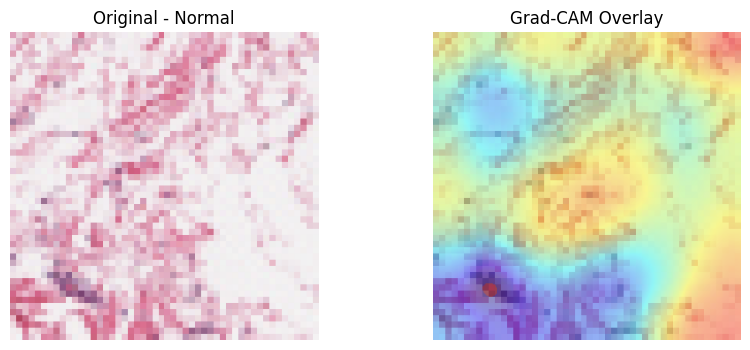

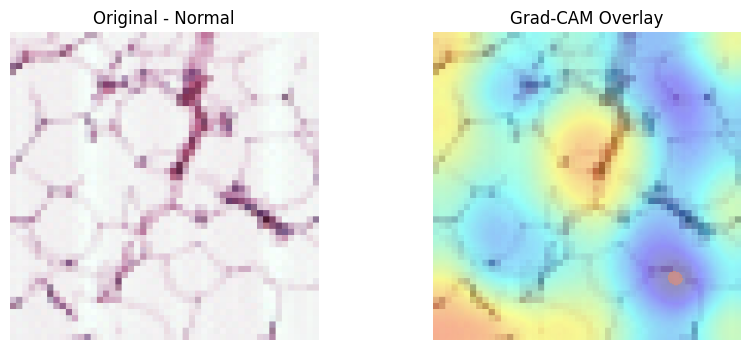

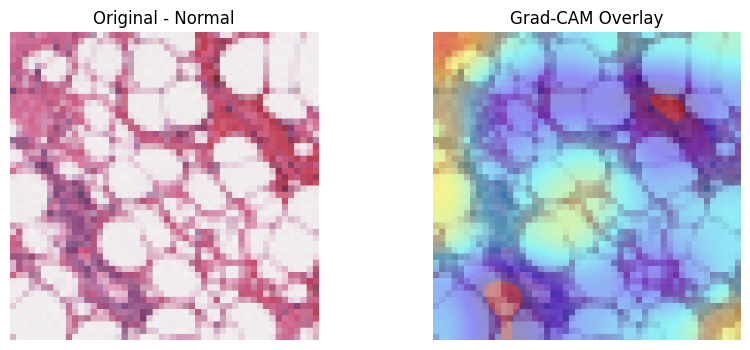

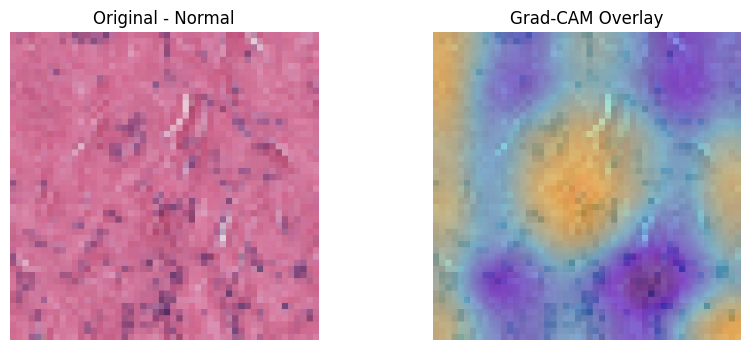

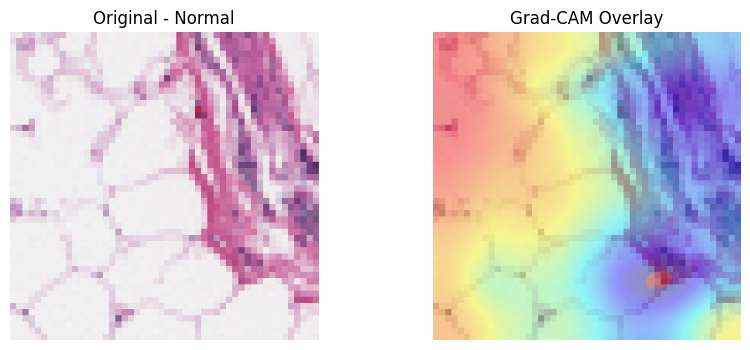

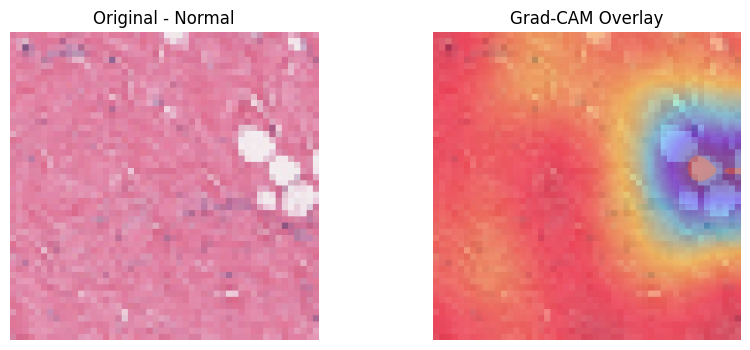

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
import cv2

IMG_SIZE_VISUAL = (299, 299) # upscaled input size for InceptionV3 model
NUM_IMAGES = 6               # number of images to display
LAST_CONV_LAYER_NAME = "mixed10" # final convolutional layer from InceptionV3 model

base_model = InceptionV3(weights= 'imagenet', include_top=False) # same base model

# load and preprocess images to be visualized by base model
def load_and_preprocess(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE_VISUAL)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img, img_array

# generate Grad-CAM heatmap for an image
def make_gradcam_heatmap(img_array, model, LAST_CONV_LAYER_NAME):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(LAST_CONV_LAYER_NAME).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        conv_outputs = tf.cast(conv_outputs, tf.float32)
        class_channel = tf.reduce_mean(predictions, axis=[1,2,3])

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8

    return heatmap

# overlays heatmap onto image with some transparency
def overlay_heatmap(img, heatmap, alpha=0.4):
    heatmap = np.array(heatmap, dtype=np.float32)
    heatmap_resized = cv2.resize(heatmap, (img.size[0], img.size[1]), interpolation=cv2.INTER_CUBIC)
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    img_np = np.array(img)

    superimposed_img = cv2.addWeighted(heatmap_colored, alpha, img_np, 1 - alpha, 0) # overlays image
    return superimposed_img

# sample and visualize images

sample_paths = train_df['filepath'].sample(NUM_IMAGES).tolist()

for img_path in sample_paths:
    img, img_array = load_and_preprocess(img_path)
    heatmap = make_gradcam_heatmap(img_array, base_model, LAST_CONV_LAYER_NAME)
    overlay = overlay_heatmap(img, heatmap)

    true_label = train_df.loc[train_df['filepath'] == img_path, 'label'].values[0]
    label_text = "Cancer" if true_label == 1 else "Normal"

    # plotting original image
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title(f"Original - {label_text}")
    plt.axis('off')

    # plotting image with overlay
    plt.subplot(1,2,2)
    plt.imshow(overlay)
    plt.title("Grad-CAM Overlay")
    plt.axis('off')
    plt.show()


In our results, the highlighted regions generally align with visible tumor areas, suggesting that the model is learning meaningful patterns relevant to breast cancer detection.

## Manual Evaluation of Results

In [ ]:
def evaluate_manual(model, dataset):
    y_true = []
    y_pred = []

    for imgs, labels in dataset:
        preds = model.predict(imgs, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend((preds >= 0.5).astype(int).ravel())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    acc = (y_true == y_pred).mean()
    return acc, y_true, y_pred

simple_acc, y_true_s, y_pred_s = evaluate_manual(simple_model, test_ds)
inception_acc, y_true_i, y_pred_i = evaluate_manual(model, test_ds)

print(f"Simple CNN Test Accuracy (manual): {simple_acc:.4f}")
print(f"InceptionV3 Test Accuracy (manual): {inception_acc:.4f}")

Simple CNN Test Accuracy (manual): 0.8185
InceptionV3 Test Accuracy (manual): 0.8128


#### Simple CNN - Training vs. Validation Accuracy

In [ ]:
train_acc = history_simple.history['accuracy']
val_acc = history_simple.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (Simple CNN)')
plt.legend()
plt.grid(True)
plt.show()

#### InceptionV3 - Training vs. Validation Accuracy

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (InceptionV3)')
plt.legend()
plt.grid(True)
plt.show()

#### Simple CNN vs. InceptionV3

In [ ]:
models = ['Simple CNN', 'InceptionV3']
test_accuracies = [simple_acc, inception_acc]

plt.figure(figsize=(6,4))
plt.bar(models, test_accuracies)
plt.ylim(0, 1)
plt.ylabel('Test Accuracy')
plt.title('Model Test Accuracy Comparison')

for i, v in enumerate(test_accuracies):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center')

plt.show()

From these results, we can see that we were able to achieve equal (in fact, even slightly better) accuracy with our own simple CNN model within 5 epochs, by virtue of having far more trainable parameters.

## Conclusion


Our goal was to classify breast cancer tissue images to detect Invasive Ductal Carcinoma (IDC), aiming for 80% accuracy as a baseline and 90% as a stretch goal. Surprisingly, our simple custom CNN performed slightly better than the pretrained InceptionV3 model, achieving 81.85% testing accuracy compared to 81.28%, even though the simple CNN showed signs of overfitting with 85% training accuracy and had 896k parameters trained on only around 277k images. This was unexpected since InceptionV3 had better training patterns with less overfitting and was already trained on a large dataset. However, we think this happended because we could only train both models for a limited number of epochs due to limited computer memory, which may not have been enough time for InceptionV3 to take full advantage of its pretrained features. We also faced other challenges, including the dataset's large 3.5GB size and no access to a really strong GPU, which forced us to scale back our implementations and focus on comparison, rather than optimization. We believe the similar performance happened because our images were relatively small (75×75 pixels), which reduced the benefit of using a complex pretrained model, especially with such short training time. This was one of the largest intial challenges we faced; inception is known to operate best at above a 200x200 image resolution, which we were simply unable to upscale to and train using with the computation power available to us. Settling for a 75x75 upscaling means we were still able to use InceptionV3, but could not get the full benefits. While both models reached our 80% baseline goal, neither hit the 90% stretch target. With more computational power, particularly longer training time and the ability to adjust more layers in InceptionV3, we expect much better results would be possible. These findings show that for small medical imaging tasks with limited computing resources, a simple CNN can work just as well as complex pretrained models.

## Sources



Simple Implementation of InceptionV3 for Image Classification using Tensorflow and Keras : https://medium.com/@armielynobinguar/simple-implementation-of-inceptionv3-for-image-classification-using-tensorflow-and-keras-6557feb9bf53
